In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List

# Converting a pano to flat images

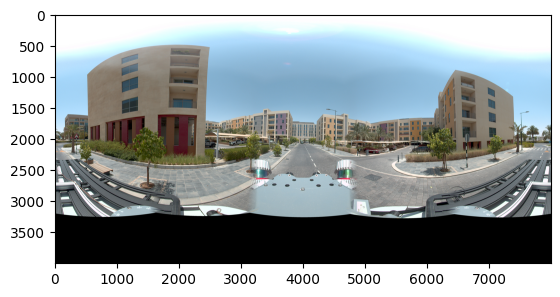

In [2]:
pano_path = r'C:\Users\HP\Downloads\360_5\pano_000005_000025.jpg'
pano_img = cv2.imread(pano_path)
plt.imshow(pano_img[:, :, ::-1])
plt.show()

In [5]:
def pano2flat(pano: np.ndarray, 
              img_size: tuple = (2048, 2048), 
              f: float = 1024,
              pixels_per_radian = 4000 / np.pi) -> List[np.ndarray]:
    
    width, height = img_size

    # Ranges of axis in dst image
    x = np.arange(-width // 2, width // 2, 1, dtype='float32').reshape(1, width)
    y = np.arange(-height // 2, height // 2, 1, dtype='float32').reshape(1, height)
    
    flat_imgs = []    
    
    # Make lateral flat images    
    for i in range(4):
        
        # Angle centers of the image in spherical coordinates
        c_phi =  i * np.pi / 2
        c_theta =  np.pi / 2

        # 'phi' corresponds to x-coordinate in pano, 'theta' corresponds to y-coordinate in pano
        # The following equations originated from pinhole model camera:
        # phi = c_phi + arctan(x / f)
        # theta = c_theta + arctan(y * cos(phi - c_phi) / f)
        map_x_1d = (c_phi + np.arctan(x / f))
        map_x  = np.ones((height, 1), dtype='float32') @ map_x_1d * pixels_per_radian
        map_y = (c_theta + np.arctan(y.T @ (np.cos(map_x_1d - c_phi)) / f)) * pixels_per_radian

        # Doing remap (borderMode = cv2.BORDER_WRAP, because maps can be out of range 
        # and pano is considered as cyclic surface of a sphere)
        lateral_img = cv2.remap(pano, map_x, map_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)
        flat_imgs.append(lateral_img)
    
    # Make vertical flat images
    for i in range(2):
        
        # Angle centers of the image in spherical coordinates
        c_phi =  np.pi
        c_theta =  i * np.pi
        
        x_2d = np.ones((height, 1), dtype='float32') @ x
        y_2d =  y.reshape(height, 1) @ np.ones((1, width), dtype='float32')

        map_x  = (c_phi + np.arctan2(y_2d, x_2d)) * pixels_per_radian 
        map_y = (c_theta + np.arctan(np.sqrt((x_2d ** 2 + y_2d ** 2)) / f)) * pixels_per_radian

        vertical_img = cv2.remap(pano, map_x, map_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT101)
        flat_imgs.append(vertical_img)
    
    return flat_imgs


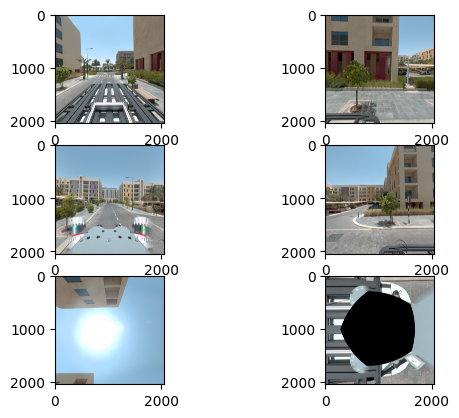

In [6]:
flat_imgs = pano2flat(pano_img)

fig = plt.figure()
for i, img in enumerate(flat_imgs):
    fig.add_subplot(3, 2, i + 1)
    plt.imshow(img[:, :, ::-1])

plt.show()

# Doing manual camera calibration

In this method we need to markup manually 3D points in point cloud and corresponding 2D point on image. Also we need camera matrix.
This prerequisites allow us to solve Perspective-n-Point (PnP) pose computation in order to find extrinsic matrix. This matrix convert 3D point from world coordinate system to the camera one.

## Perspective-n-Point (PnP) pose computation 

In [7]:
# Points in 3d space
object_points = np.array(
    [
        [-805465, 261912, 176528],
        [-999003, 271359, 176466],
        
        [-878350, 265396, 150586],
        [-903028, 266616, 150125],
        
        [-902612, 266558, 127889],
        [-878333, 265380, 127893],
    ],
dtype='float32')   

# Points in 2d image
image_points = np.array(
    [
        [1192, 602],
        [122, 635],

        [746, 539],
        [596, 545],
        
        [524, 469],
        [700, 460],
    ],  
dtype='float32')

# Intrisic camera matrix
fx = 1024
fy = 1024
cx = 1024
cy = 1024
camera_matrix = np.array(
    [
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1],
    ],
dtype='float32')

In [8]:
# Points in 3d space # 25_0, 25_2, 25_2
object_points = np.array(
    [
    #     [-1035901,   146850,   -31172],
    #    [-1031841,   217217,   -32559],
    #    [ -995746,   146650,   -30657],
    #    [ -995665,   215647,   -31925],
    
        # [-527445,  195817,  -27973],
        # [-465033,  120114,  -27375],
        # [-657825,  201949,  -27752],
        # [-592336,  127326,  -26963],
        
        [369520.940300, 2681851.457701, 237.075394],
        [369527.002998, 2681850.810200, 237.340195],
        [369533.004402, 2681850.936701, 237.183701],
        [369534.051102, 2681849.673901, 237.164902],
        [369547.639500, 2681849.093000, 237.143997],
        [369549.373798, 2681849.919201, 237.380707],
        [369553.558399, 2681841.628500, 237.315399],
        [369540.664700, 2681842.211000, 237.359497],
        [369528.866997, 2681841.867200, 237.438202],
    ],
dtype='float32')   

# Points in 2d image
image_points = np.array(
    [   # 25_0
        # [756, 1144],
        # [1118, 1145],
        # [690, 1180],
        # [1143, 1170],
        
        # 25 2
        # [916, 1124],
        # [1144, 1111],
        # [834, 1206],
        # [1225, 1151],
        
        # 25_2
        [220, 1613],
        [670, 1272],
        [780, 1184],
        [865, 1189],
        [924, 1120],
        [890, 1118],
        [1130, 1108],
        [1204, 1144],
        [1455, 1223],
    ],  
dtype='float32')

# Intrisic camera matrix
fx = 1024
fy = 1024
cx = 1024
cy = 1024
camera_matrix = np.array(
    [
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1],
    ],
dtype='float32')

In [13]:
# Find extrisic calibration
retval, rvec, tvec = cv2.solvePnP(object_points, image_points, camera_matrix, None)#, flags=cv2.SOLVEPNP_SQPNP)

print(rvec)
print(tvec)

# [[0.95554057]
#  [1.43618446]
#  [0.18965009]]
# [[ 148784.52434517]
#  [ 575478.09090596]
#  [-936351.76409538]]

[[ 1.17159539]
 [-1.25932201]
 [ 1.27791234]]
[[2702800.10404921]
 [  21989.63895119]
 [-152448.05627692]]


In [14]:
# Get POV
def get_homography(rvec, tvec):
    h_mat = np.eye(4, dtype='float32')
    rot_mat = cv2.Rodrigues(rvec)[0]
    h_mat[0:3, 0:3] = rot_mat
    h_mat[0:3, 3:4] = tvec
    
    return h_mat

h = get_homography(rvec, tvec)
print(h)
h_inv = np.linalg.inv(h)
print(h_inv)
print(h @ np.array([[-8.33654750e+05],
 [ 3.42273469e+05],
 [-7.70722656e+03],
 [ 1.00000000e+00]]))
h

# [-837810, 184720, -4279], # 25   

[[-8.0546811e-02 -9.9671513e-01  8.4343394e-03  2.7028000e+06]
 [ 6.1716586e-03 -8.9603812e-03 -9.9994081e-01  2.1989639e+04]
 [ 9.9673170e-01 -8.0489986e-02  6.8731154e-03 -1.5244806e+05]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[-8.0546811e-02  6.1716586e-03  9.9673176e-01  3.6951603e+05]
 [-9.9671513e-01 -8.9603812e-03 -8.0489993e-02  2.6818482e+06]
 [ 8.4343394e-03 -9.9994081e-01  6.8731159e-03  2.3979749e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 2.42873408e+06]
 [ 2.14844758e+04]
 [-1.01098074e+06]
 [ 1.00000000e+00]]


array([[-8.0546811e-02, -9.9671513e-01,  8.4343394e-03,  2.7028000e+06],
       [ 6.1716586e-03, -8.9603812e-03, -9.9994081e-01,  2.1989639e+04],
       [ 9.9673170e-01, -8.0489986e-02,  6.8731154e-03, -1.5244806e+05],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

## Vizualize image points projection to 3D space

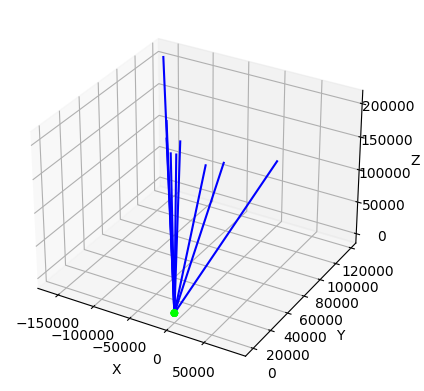

In [11]:
def get_homography(rvec, tvec):
    h_mat = np.eye(4, dtype='float32')
    rot_mat = cv2.Rodrigues(rvec)[0]
    h_mat[0:3, 0:3] = rot_mat
    h_mat[0:3, 3:4] = tvec
    
    return h_mat


h_mat = get_homography(rvec, tvec)
ray_points = np.ones((len(image_points), 3), dtype='float32') * 1024
ray_points[:, 0:2] = image_points
ray_points[:, 0] -= fx
ray_points[:, 1] -= fy
ray_points *= 200
object_points_cam = cv2.perspectiveTransform(object_points.reshape(-1, 1, 3), h_mat).reshape(-1, 3)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for pt in ray_points:
    xs = [0, pt[0]]
    ys = [0, pt[1]]
    zs = [0, pt[2]]
    ax.plot(xs, ys, zs, color='#0000ff')

xs = object_points_cam.T[0]
ys = object_points_cam.T[1]
zs = object_points_cam.T[2]
ax.scatter(xs, ys, zs, 'o', color='#00ff00')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

pov_world [[-808035.94    185680.69     -2578.5596]]


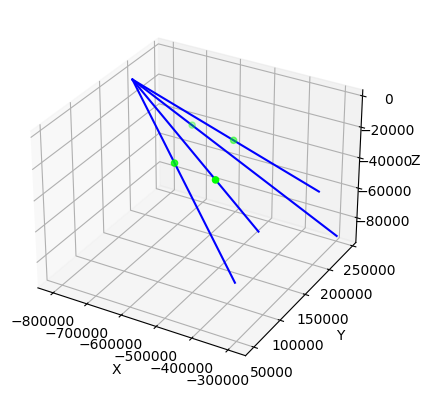

In [26]:
def get_homography(rvec, tvec):
    h_mat = np.eye(4, dtype='float32')
    rot_mat = cv2.Rodrigues(rvec)[0]
    h_mat[0:3, 0:3] = rot_mat
    h_mat[0:3, 3:4] = tvec
    
    return h_mat


h_mat = get_homography(rvec, tvec)
h_mat_inv = np.linalg.inv(h_mat)

ray_points = np.ones((len(image_points), 3), dtype='float32') * 1024
ray_points[:, 0:2] = image_points
ray_points[:, 0] -= fx
ray_points[:, 1] -= fy
ray_points *= 500

ray_points_world = cv2.perspectiveTransform(ray_points.reshape(-1, 1, 3), h_mat_inv).reshape(-1, 3)

pov = np.zeros((1, 3), dtype='float32')
pov_world = cv2.perspectiveTransform(pov.reshape(-1, 1, 3), h_mat_inv).reshape(-1, 3)
print('pov_world', pov_world)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for pt in ray_points_world:
    xs = [pov_world[0][0], pt[0]]
    ys = [pov_world[0][1], pt[1]]
    zs = [pov_world[0][2], pt[2]]
    ax.plot(xs, ys, zs, color='#0000ff')

xs = object_points.T[0]
ys = object_points.T[1]
zs = object_points.T[2]
ax.scatter(xs, ys, zs, 'o', color='#00ff00')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
# pov_world [[-837605.06   192683.58    -5013.305]] # 25_0
# pov_world [[-808035.94    185680.69     -2578.5596]] # 25_2

## Vizualize 3D point projection to 2D image

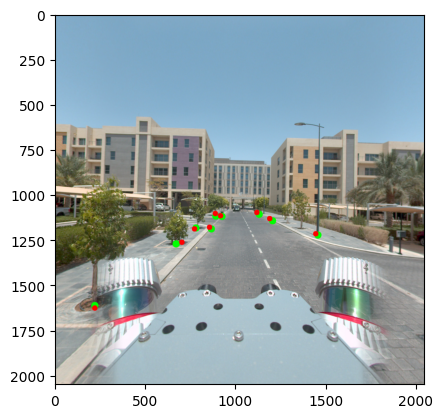

In [15]:
# Vis
img = flat_imgs[2].copy()
res_image_points = cv2.projectPoints(object_points, rvec, tvec, camera_matrix, None)[0].reshape(-1, 2)

for pt in image_points:
    cv2.circle(img, (int(pt[0]), int(pt[1])), 20, (0, 255, 0), -1)
    
for pt in res_image_points:
    cv2.circle(img, (int(pt[0]), int(pt[1])), 15, (0, 0, 255), -1)
    
plt.imshow(img[:, :, ::-1])
plt.show()


# Calibration with visual odometry